# TP2
## CEIA - Cohorte 7 - 2022
## Matias Porra

In [8]:
import numpy as np
import cv2 as cv
import time
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8.0, 8.0)

### Implementar la función create_gauss_filter (h, w, k_size, sigma) para crear filtros gaussianos para filtrado espectral. Debe retornar un filtro gaussiano de tamaño HxW en dominio espacial y su transformada de Fourier.

In [9]:

def create_gauss_filter(h, w, k_size, sigma):
    #Creo el filtro
    gauss_kernel = cv.getGaussianKernel(k_size, sigma)
    gauss_kernel = np.outer(gauss_kernel, gauss_kernel)
    gauss_kernel = gauss_kernel / np.sum(gauss_kernel)

    #Creo la matriz de ceros y opero punto a punto partiendo del centro
    filter_ = np.zeros((h, w))
    row = int(w/2) - int(k_size/2)
    col = int(h/2) - int(k_size/2)
    for i in range(0, k_size):
        for j in range(0, k_size):
            filter_[col + i, row + j] = gauss_kernel[i,j]

    # Transformada de Fourier
    ft = np.fft.fft2(filter_)
    ft = np.fft.fftshift(ft)

    return filter_, ft


#### Graficar ambas representaciones para diferentes tamaños de kernel y sigma. 

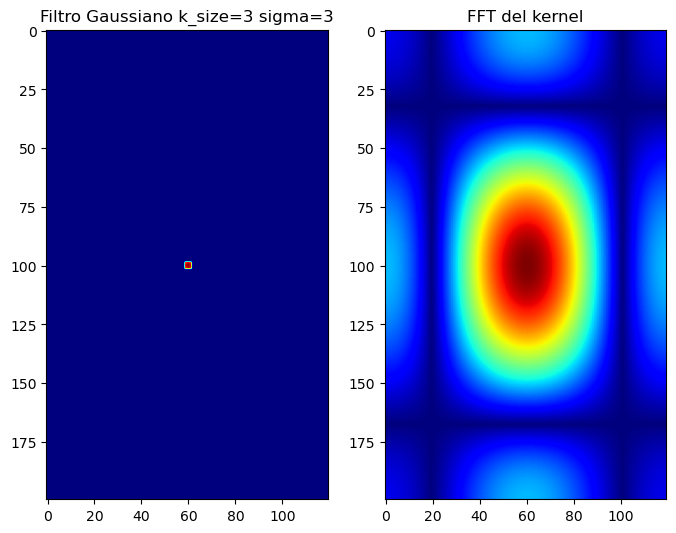

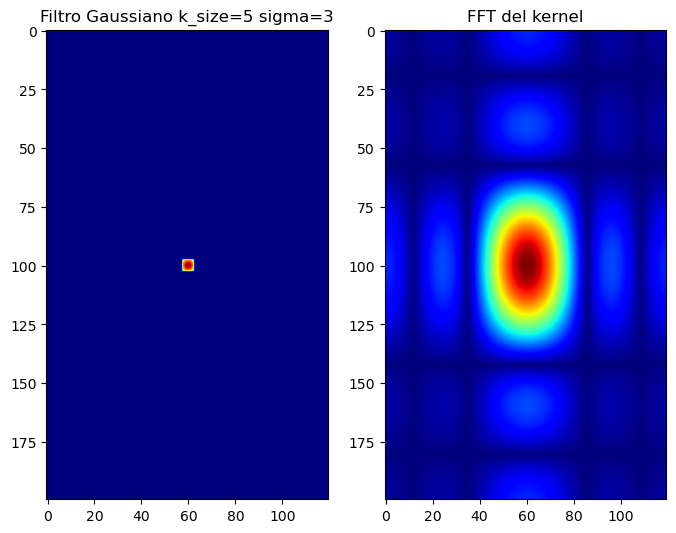

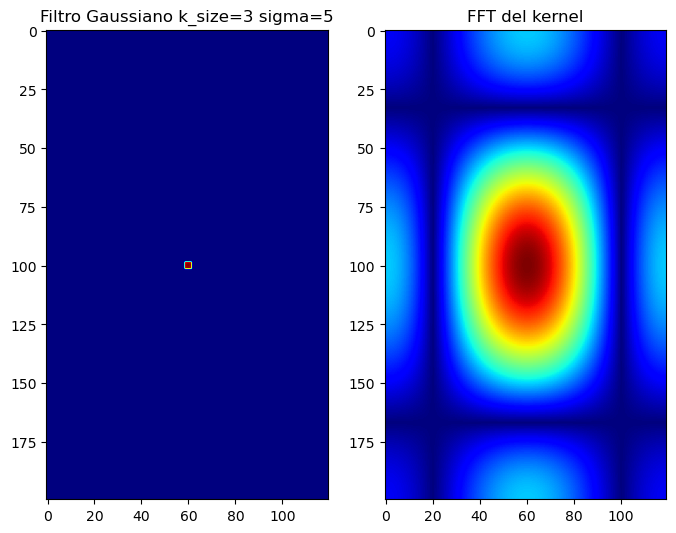

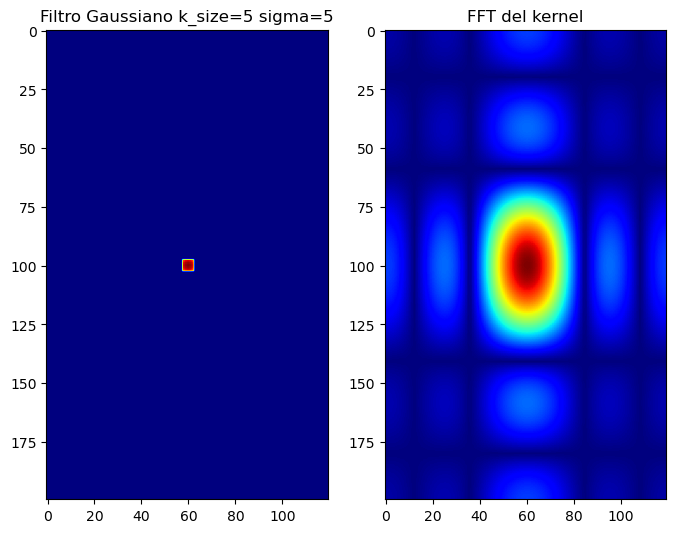

In [10]:
#Itero para diferentes valores de sigma y k-size

for sigma in [3,5]:
    for k_size in [3,5]:
        filtro, ft = create_gauss_filter(200, 120, k_size, sigma)
        magnitude_spectrum = 20*np.log(np.abs(ft)) 
        
        #Ploteo
        plt.subplot(121)
        plt.imshow(filtro, cmap="jet")
        plt.title(f"Filtro Gaussiano k_size={k_size} sigma={sigma}")
        plt.subplot(122)
        plt.imshow(np.abs(ft), cmap="jet")
        plt.title("FFT del kernel")
        
        plt.show()

#### Aplicar el filtro una imagen para validar el funcionamiento en el dominio espectral.

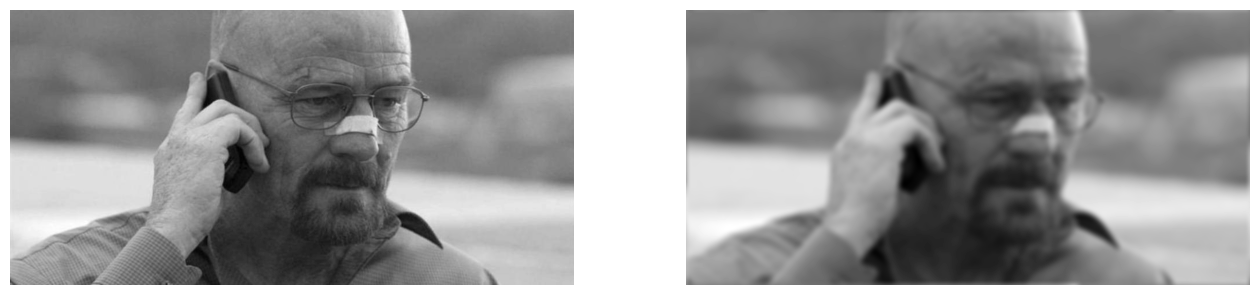

In [11]:
#Traigo mi imagen
img = cv.imread('img/IWon.jpg', cv.IMREAD_GRAYSCALE)

# parametros
k_size = 17
sigma = 5
#Tomo ancho y alto de la imagen
height, width = img.shape
# Creo el filtro
g_filter, g_filter_ft = create_gauss_filter(height, width, k_size, sigma)

# Calculo la FFT nuevamente
shifted_fft = np.fft.fftshift(np.fft.fft2(img))   
filtered = shifted_fft * g_filter_ft        

# Aplico la antitransformada para obtener la imagen filtrada
f_ishift = np.fft.ifftshift(filtered) 
img_filtrada = np.real(np.fft.ifft2(f_ishift)) 
img_filtrada = np.fft.ifftshift(img_filtrada)

# Ploteo
fig, ax = plt.subplots(1,2,figsize=(16,16))
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(img_filtrada, cmap='gray')
plt.axis('off')
plt.show()      

#### Usando el método descripto en el paper "Image Sharpness Measure for Blurred Images in Frequency Domain" comparar el resultado de un filtrado por convolución con el filtrado espectral.

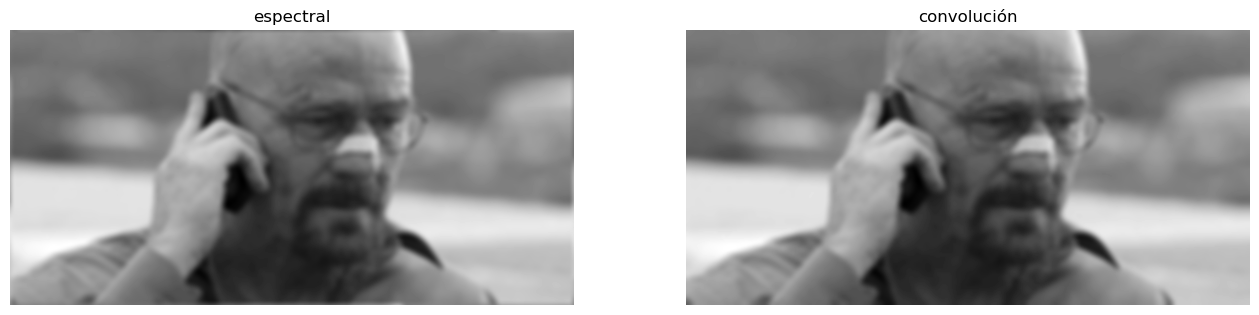

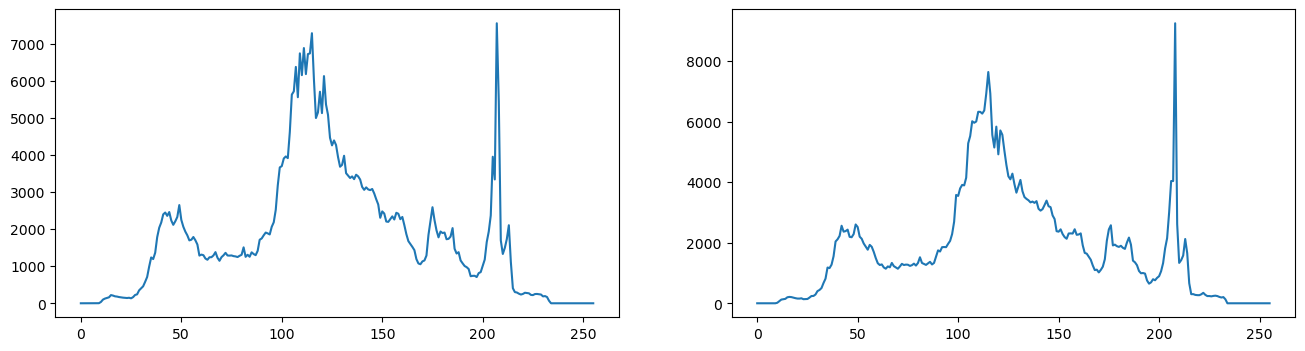

In [12]:
# Aplicamos el metodo Gausseano.

img_filtrada_conv = cv.GaussianBlur(img, ksize=(k_size, k_size),sigmaX=sigma, sigmaY=sigma)

#Ploteo
fig, ax = plt.subplots(1,2,figsize=(16,16))
plt.subplot(1,2,1)
plt.imshow(img_filtrada, cmap='gray')
plt.title("espectral"); plt.axis('off')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(img_filtrada_conv, cmap='gray')
plt.title("convolución")
plt.axis('off')
plt.show()
fig, ax = plt.subplots(1,2, figsize=(16,4))
i = 0
for img in [img_filtrada,img_filtrada_conv]:
    hist, bins = np.histogram(img.ravel(),256,[0,256])
    ax[i].plot(hist)
    i += 1
plt.show()

##### Como conclusion aca, a simple vista las imagenes son practicamente iguales, si comparo los histogramas veo que los picos y valles no son tan pronunciados en la convolucion (por ej entre el 100 y el 150) lo que me da a entender que la principal diferencia entre estos filtros es que quiza hay una especie de "filtrado" en las frecuencias, que produciria que falten algunas frecuencias altas entonces las imagenes quedan difuminadas de maneras diferentes. (porque perderia algunos bordes)

#### Repetir la comparación usando uno de los métodos descriptos en el apéndice del paper "Analysis of focus measure operators in shape-from-focus"

##### Intentare usar este metodo, de un DCT modificado

<img src="DCT.png">

#### Creo el kernel 
##### Intento hacer la convolucion del kernel con la imagen de dos maneras, pero no estoy seguro cual es la correcta.

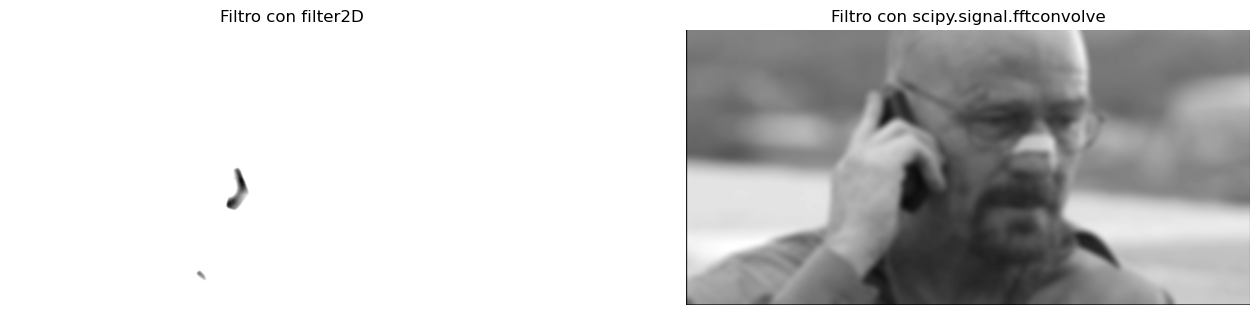

In [13]:
kernel = np.array([[1, 1, -1, 11],
                    [1, 1, -1, -1],
                    [-1, -1, 1, 1]])

#Intento con filter2D
identity = cv.filter2D(src=img, ddepth=-1, kernel=kernel) 

# Intento con scipy.signal.fftconvolve
import scipy
blurred = scipy.signal.fftconvolve(img, kernel, mode='same')

fig, ax = plt.subplots(1,2,figsize=(16,16))
plt.subplot(1,2,1)
plt.imshow(identity, cmap='gray')
plt.title("Filtro con filter2D"); plt.axis('off')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(blurred, cmap='gray')
plt.title("Filtro con scipy.signal.fftconvolve")
plt.axis('off')
plt.show()     

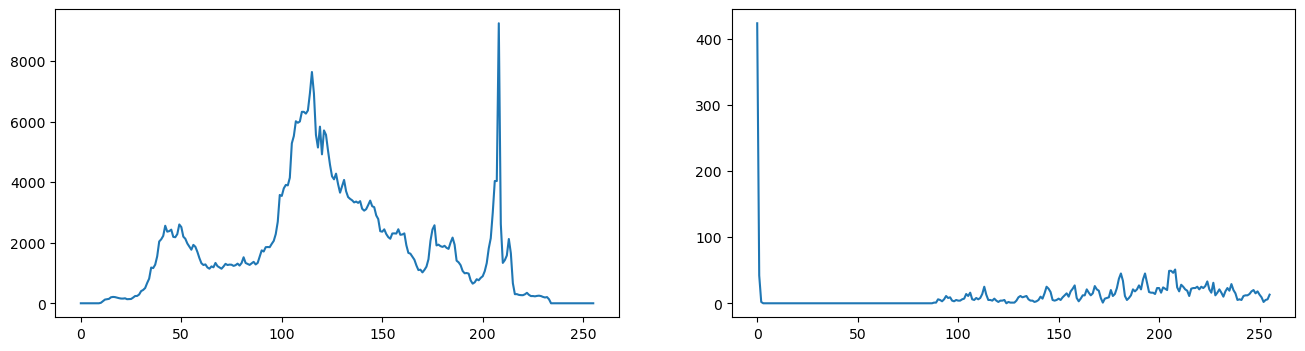

In [14]:
fig, ax = plt.subplots(1,2, figsize=(16,4))
i = 0
for img in [img,blurred]:
    hist, bins = np.histogram(img.ravel(),256,[0,256])
    ax[i].plot(hist)
    i += 1
plt.show()